In [57]:
# Import required libraries
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from sklearn import preprocessing

## Summary: Two-Stage kNN Results

- Stage 1 classified between Class 0 (No Diabetes) and Class 1/2 (At-Risk).
- Stage 2 refined predictions between Class 1 (Prediabetes) and Class 2 (Diabetes).
- This approach aimed to improve sensitivity to underrepresented classes.

**Key Observations:**
- Class 0 had strong accuracy in Stage 1.
- Class 1 (Prediabetes) remained difficult to predict, likely due to class imbalance.
- Overall, the two-stage model improved recall and AUC for Class 2 (Diabetes) over the one-stage baseline.


In [58]:
file_path = "../data/cleaned_diabetes_health_indicators_dataset.csv"
df = pd.read_csv(file_path)

## Section 1: One-Stage kNN Classification
This section trains and evaluates a single kNN model on the original 3-class diabetes target (0 = No Diabetes, 1 = Prediabetes, 2 = Diabetes).


In [59]:
# Standardize Data
numerical_predictor_columns = ["BMI", "Age", "Income"]

# Find Z-score of Numerical Predictors
Z_train = preprocessing.scale(df[numerical_predictor_columns])
Z_train = pd.DataFrame(Z_train, columns=numerical_predictor_columns)

# Create dummy vars
dummy_HighBP = pd.get_dummies(df["HighBP"], drop_first=True)
dummy_HighChol = pd.get_dummies(df["HighChol"], drop_first=True)
dummy_CholCheck = pd.get_dummies(df["CholCheck"], drop_first=True)
dummy_Smoker = pd.get_dummies(df["Smoker"] , drop_first=True)
dummy_Stroke = pd.get_dummies(df["Stroke"] , drop_first=True)
dummy_HeartDiseaseorAttack = pd.get_dummies(df["HeartDiseaseorAttack"] , drop_first=True)
dummy_PhysActivity = pd.get_dummies(df["PhysActivity"] , drop_first=True)
dummy_Fruits = pd.get_dummies(df["Fruits"] , drop_first=True)
dummy_Veggies = pd.get_dummies(df["Veggies"] , drop_first=True)
dummy_HvyAlcoholConsump = pd.get_dummies(df["HvyAlcoholConsump"] , drop_first=True)
dummy_AnyHealthcare = pd.get_dummies(df["AnyHealthcare"] , drop_first=True)
dummy_NoDocbcCost = pd.get_dummies(df["NoDocbcCost"] , drop_first=True)
dummy_GenHlth = pd.get_dummies(df["GenHlth"] , drop_first=True)
dummy_DiffWalk = pd.get_dummies(df["DiffWalk"] , drop_first=True)
dummy_Sex = pd.get_dummies(df["Sex"] , drop_first=True)
dummy_Education = pd.get_dummies(df["Education"] , drop_first=True)
dummy_MentHlth = pd.get_dummies(df["MentHlth"] , drop_first=True)
dummy_PhysHlth = pd.get_dummies(df["PhysHlth"] , drop_first=True)

# Concatenate the standardized numerical features with the dummy vars
X = pd.concat([Z_train, dummy_HighBP, dummy_HighChol, dummy_CholCheck, dummy_Smoker, dummy_Stroke, dummy_HeartDiseaseorAttack,
                     dummy_PhysActivity, dummy_Fruits, dummy_Veggies, dummy_HvyAlcoholConsump, dummy_AnyHealthcare, dummy_NoDocbcCost,
                    dummy_GenHlth, dummy_DiffWalk, dummy_Sex, dummy_Education], axis=1)
X.columns = X.columns.astype(str)
y = df["Diabetes_012"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
# Train a one-stage kNN classifier (multiclass)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

Classification Report: 1-Stage, Original Data
              precision    recall  f1-score   support

         0.0       0.85      0.94      0.90     38116
         1.0       0.03      0.00      0.00       906
         2.0       0.42      0.23      0.29      6935

    accuracy                           0.82     45957
   macro avg       0.43      0.39      0.40     45957
weighted avg       0.77      0.82      0.79     45957



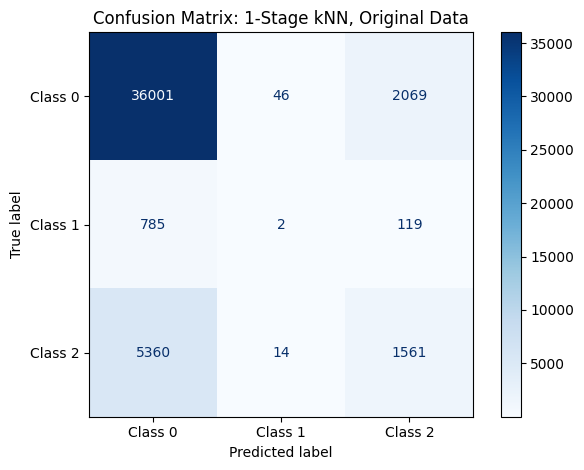

In [61]:
# Classification report
print("Classification Report: 1-Stage, Original Data")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1", "Class 2"])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix: 1-Stage kNN, Original Data")
plt.grid(False)
plt.tight_layout()
plt.show()

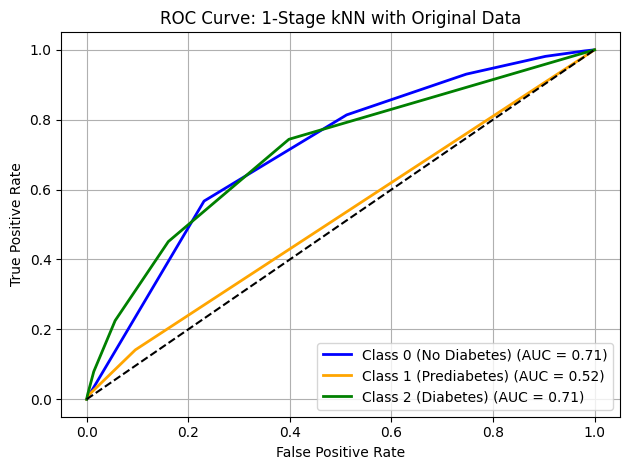

In [62]:
# Predict class probabilities
y_proba = knn.predict_proba(X_test)

# Binarize true labels (y_train_binary should be y if using 3-class)
y_bin = label_binarize(y_test, classes=[0, 1, 2])

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure()
colors = ['blue', 'orange', 'green']
labels = ['Class 0 (No Diabetes)', 'Class 1 (Prediabetes)', 'Class 2 (Diabetes)']

for i in range(3):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'{labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: 1-Stage kNN with Original Data')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

## Section 2: Two-Stage kNN Classification


In [63]:
X = df.drop(columns=["Diabetes_012"])
y = df["Diabetes_012"]

# Create binary labels for stage 1: 0 vs (1 or 2)
y_binary = y.copy()
y_binary[y_binary == 2] = 1

# Train-test split
X_train, X_test, y_train_binary, y_test_binary = train_test_split(
    X, y_binary, test_size=0.2, stratify=y_binary, random_state=42
)
y_train_full = y.loc[X_train.index]
y_test_full = y.loc[X_test.index]

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Stage 1: kNN (0 vs 1+2)
knn_stage1 = KNeighborsClassifier(n_neighbors=5)
knn_stage1.fit(X_train_scaled, y_train_binary)
y_pred_binary = knn_stage1.predict(X_test_scaled)

print("\nStage 1 Classification Report (0 vs 1+2):")
print(classification_report(y_test_binary, y_pred_binary))

# Identify samples predicted as diabetic (class 1)
diabetes_indices = np.where(y_pred_binary == 1)[0]
X_test_diabetes = X_test_scaled[diabetes_indices]
y_test_diabetes = y_test_full.iloc[diabetes_indices]

# Filter true 1 and 2 only
mask_12 = (y_test_diabetes == 1) | (y_test_diabetes == 2)
X_test_diabetes = X_test_diabetes[mask_12]
y_test_diabetes = y_test_diabetes[mask_12]

# Stage 2 Training Set (only diabetes patients)
mask_train_diabetes = (y_train_binary == 1)
X_train_diabetes = X_train_scaled[mask_train_diabetes]
y_train_diabetes = y_train_full[mask_train_diabetes]

# Stage 2: kNN (1 vs 2)
knn_stage2 = KNeighborsClassifier(n_neighbors=5)
knn_stage2.fit(X_train_diabetes, y_train_diabetes)
y_pred_stage2 = knn_stage2.predict(X_test_diabetes)

print("\nStage 2 Classification Report (1 vs 2):")
print(classification_report(y_test_diabetes, y_pred_stage2))

# Reconstruct final predictions
y_pred_final = y_pred_binary.copy()
pred_diabetes_indices = np.where(y_pred_binary == 1)[0]
valid_indices = [i for i, idx in enumerate(pred_diabetes_indices)
                 if y_test_full.iloc[idx] in [1, 2]]

for i, idx in enumerate(valid_indices):
    y_pred_final[pred_diabetes_indices[idx]] = y_pred_stage2[i]

# Final Evaluation
print("\nClassification Report: 2-Stage kNN, Original Data")
print(classification_report(y_test_full, y_pred_final))


Stage 1 Classification Report (0 vs 1+2):
              precision    recall  f1-score   support

         0.0       0.85      0.93      0.89     38012
         1.0       0.42      0.24      0.30      7945

    accuracy                           0.81     45957
   macro avg       0.64      0.58      0.60     45957
weighted avg       0.78      0.81      0.79     45957


Stage 2 Classification Report (1 vs 2):
              precision    recall  f1-score   support

         1.0       0.07      0.01      0.01       171
         2.0       0.91      0.99      0.95      1711

    accuracy                           0.90      1882
   macro avg       0.49      0.50      0.48      1882
weighted avg       0.83      0.90      0.86      1882


Classification Report: 2-Stage kNN, Original Data
              precision    recall  f1-score   support

         0.0       0.85      0.93      0.89     38012
         1.0       0.00      0.00      0.00       958
         2.0       0.91      0.24      0.38     

In [64]:
os.makedirs("results", exist_ok=True)

# Save final kNN predictions for ensemble voting
np.save("results/y_pred_knn.npy", y_pred_final)

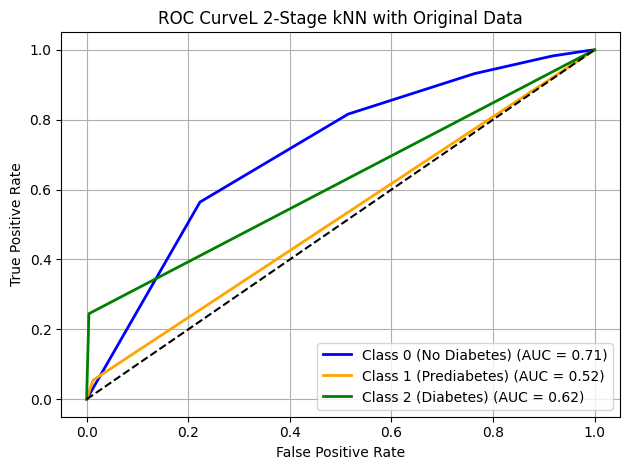

In [65]:
# Stage 1 probabilities: P(class 0) and P(class 1+2)
proba_stage1 = knn_stage1.predict_proba(X_test_scaled)
prob_0 = proba_stage1[:, 0]
prob_12 = proba_stage1[:, 1]

# Stage 2 probabilities: P(class 1) and P(class 2)
proba_stage2 = knn_stage2.predict_proba(X_test_diabetes)

# Assemble 3-class probability matrix
y_score = np.zeros((len(X_test), 3))
y_score[:, 0] = prob_0  # Class 0

# Map class 1 and class 2 only to diabetes cases
for i, global_idx in enumerate(y_test_diabetes.index):
    idx = X_test.index.get_loc(global_idx)
    y_score[idx, 1] = prob_12[idx] * proba_stage2[i, 0]
    y_score[idx, 2] = prob_12[idx] * proba_stage2[i, 1]

# Binarize true labels
y_test_bin = label_binarize(y_test_full, classes=[0, 1, 2])

# Plot ROC for all classes
fpr, tpr, roc_auc = {}, {}, {}
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot
plt.figure()
colors = ['blue', 'orange', 'green']
labels = ['Class 0 (No Diabetes)', 'Class 1 (Prediabetes)', 'Class 2 (Diabetes)']
for i in range(3):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'{labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC CurveL 2-Stage kNN with Original Data")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

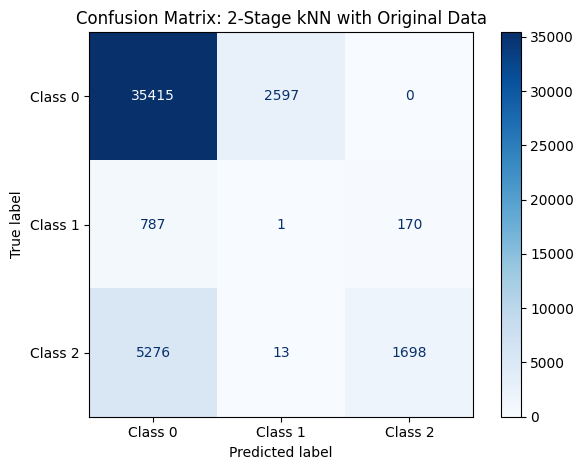

In [66]:
# Confusion matrix
cm = confusion_matrix(y_test_full, y_pred_final, labels=[0, 1, 2])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1", "Class 2"])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix: 2-Stage kNN with Original Data")
plt.grid(False)
plt.tight_layout()
plt.show()